In [84]:
"""
Multi-armed bandit:
- A coin machine has N levers (arms) each with different expected wins
- The average wins are chosen based on gaussian (mean 0, variance 1)
- The rewards are then a gaussian centered on the average win and variance 1

This is not really a Markovian Decision Process nor embodies the full problem of Reinforcement Learning:
- each state is independent
- each reward is therefore independent
"""

%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn

In [101]:
import abc
import numpy as np
from typing import *


"""
Definition of the environment: the problem
"""


Reward = float


class Distribution(abc.ABC):
    @abc.abstractmethod
    def __call__(self) -> Reward:
        pass

    
class MultiArmedBanditEnv:
    def __init__(self, arms_distributions: List[Distribution]):
        self.arms_distributions = arms_distributions
        self.actions = np.array(range(len(self.arms_distributions)))
    
    def get_state(self):
        return 0
    
    def get_actions(self):
        return self.actions
    
    def step(self, action) -> Reward:
        return self.arms_distributions[action]()


class Agent(abc.ABC):
    @abc.abstractmethod
    def step(self, environment: MultiArmedBanditEnv, epoch_count: int) -> List[Reward]:
        pass
    

"""
Different approach to solve the problem
"""


class RandomAgent(Agent):
    def step(self, environment: MultiArmedBanditEnv, epoch_count: int) -> List[Reward]:
        rewards = []
        actions = environment.get_actions()
        for action in np.random.choice(actions, size=epoch_count):
            rewards.append(environment.step(action))
        return rewards

    
class EpsilonGreedyAgent(Agent):
    def __init__(self,
                 environment: MultiArmedBanditEnv,
                 epsilon: float,        # percentage of time we select a random action
                 alpha: float = None,   # the atenuation factor (default is running average)
                 init_value: float = 0. # the initial estimation of the value (allows optimistic to better explore)
                ):
        self.actions = environment.get_actions()
        self.action_values = np.full(len(self.actions), init_value)
        self.action_counts = np.ones(len(self.actions))
        self.epsilon = epsilon
        self.alpha = alpha
    
    def step(self, environment: MultiArmedBanditEnv, epoch_count: int) -> List[Reward]:
        rewards = []
        for epoch in range(epoch_count):
            if np.random.uniform(low=0., high=1.) < self.epsilon:
                # TODO - try ponderated random choice (the least selected action first for instance)
                action_index = np.random.randint(low=0, high=len(self.actions))
            else:
                action_index = self._select_best_value(self.action_values)
            reward = environment.step(self.actions[action_index])
            step_alpha = self.alpha or 1 / self.action_counts[action_index]
            self.action_values[action_index] += step_alpha * (reward - self.action_values[action_index])
            self.action_counts[action_index] += 1
            rewards.append(reward)
        return np.array(rewards)
    
    def _select_best_value(self, action_values):
        # TODO - check this is a valid kind of reservoir sampling
        highest_action = None
        highest_value = float('-inf')
        equal_actions_nb = 1
        for i, value in enumerate(action_values):
            if value > highest_value:
                highest_value = value
                highest_action = i
                equal_actions_nb = 1
            elif value == highest_value:
                equal_actions_nb += 1
                if np.random.randint(low=0, high=equal_actions_nb) == 0:
                    highest_action = i
        return highest_action

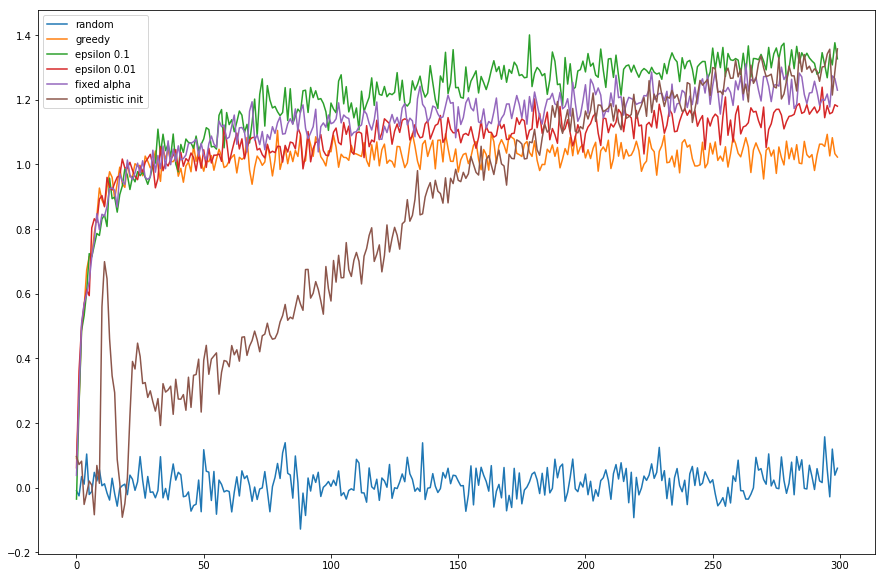

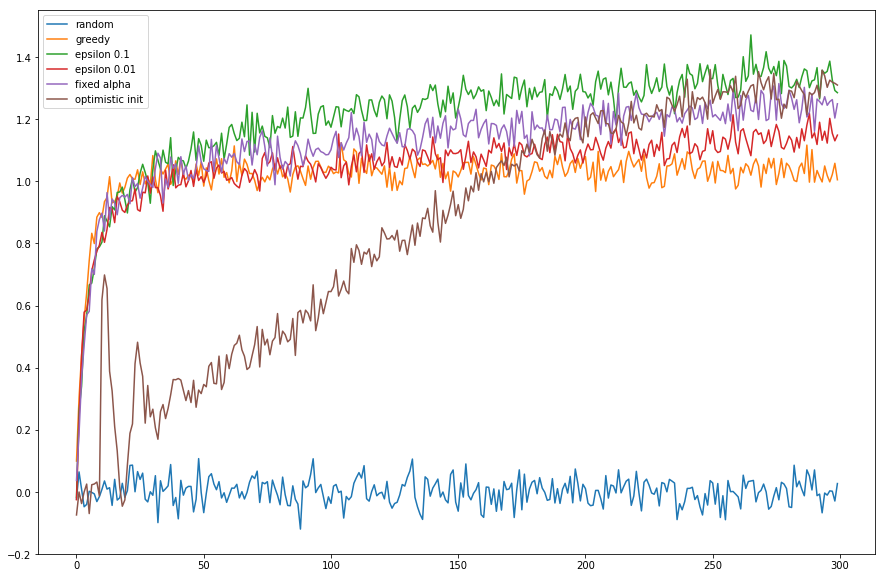

In [117]:
class GaussianDistribution(Distribution):
    def __init__(self, mean: float):
        self.mean = mean
        
    def __call__(self) -> Reward:
        return np.random.normal(loc=self.mean, scale=1)


def running_avg(previous_avg, count: int, new_value):
    previous_avg += 1 / count * (new_value - previous_avg)
    
    
def competition(round_count: int, epoch_by_round: int, arm_count: int, stability_period: int = None):
    stability_period = stability_period or epoch_by_round
    agent_factories = [
        lambda env: RandomAgent(),
        lambda env: EpsilonGreedyAgent(env, epsilon=-1.), # Greedy
        lambda env: EpsilonGreedyAgent(env, epsilon=0.1),
        lambda env: EpsilonGreedyAgent(env, epsilon=0.01),
        lambda env: EpsilonGreedyAgent(env, epsilon=0.1, alpha=0.1),
        lambda env: EpsilonGreedyAgent(env, epsilon=0.1, alpha=0.1, init_value=5.)
    ]
    
    rewards = [np.zeros(epoch_by_round) for _ in range(len(agent_factories))]
    
    for n in range(round_count):
        means = np.random.normal(loc=0., scale=1., size=arm_count)
        env = MultiArmedBanditEnv([GaussianDistribution(mean) for mean in means])
        agents = [factory(env) for factory in agent_factories]
        round_rewards = [[] for _ in range(len(agents))]
        
        remaining_epochs = epoch_by_round
        while remaining_epochs > 0:
            means = np.random.normal(loc=0., scale=1., size=arm_count)
            env.arm_distributions = [GaussianDistribution(mean) for mean in means]
            for i, agent in enumerate(agents):
                step_count = min(remaining_epochs, stability_period)
                round_rewards[i].append(agent.step(env, step_count))
            remaining_epochs -= stability_period
        
        for i, agent in enumerate(agents):
            round_rewards[i] = np.concatenate(round_rewards[i], axis=0)
            running_avg(rewards[i], n+1, round_rewards[i])
        
    fig, ax = plt.subplots(figsize=(15, 10))
    time_steps = np.array(range(epoch_by_round))
    ax.plot(time_steps, rewards[0], label='random')
    ax.plot(time_steps, rewards[1], label='greedy')
    ax.plot(time_steps, rewards[2], label='epsilon 0.1')
    ax.plot(time_steps, rewards[3], label='epsilon 0.01')
    ax.plot(time_steps, rewards[4], label='fixed alpha')
    ax.plot(time_steps, rewards[5], label='optimistic init')
    ax.legend()
    plt.show()


competition(round_count=1000, epoch_by_round=300, arm_count=10)
competition(round_count=1000, epoch_by_round=300, arm_count=10, stability_period=50)